In [1]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.applications import ResNet101V2
from keras import models, layers, optimizers
from keras.callbacks import LearningRateScheduler, TensorBoard
from keras.utils import to_categorical


import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

import numpy as np

# Keras Image Data Loading
ref: https://keras.io/api/data_loading/image/

In [2]:

def create_dataset(data_dir, shuffle=True):
    # Use ImageDataGenerator for normalization
    datagen = ImageDataGenerator(rescale=1./255)

    # Create a TensorFlow dataset
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='categorical',
        color_mode='rgb',
        image_size=(224, 224),
        shuffle=shuffle,
        seed=42,
        validation_split=0.2,
        subset="training",
        interpolation="bilinear",
        crop_to_aspect_ratio=True
    )

    val_dataset = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='categorical',
        color_mode='rgb',
        image_size=(224, 224),
        shuffle=shuffle,
        seed=42,
        validation_split=0.2,
        subset="validation",
        interpolation="bilinear",
        crop_to_aspect_ratio=True
    )

    # Determine batch size dynamically
    #batch_size = tf.data.experimental.cardinality(train_dataset).numpy()
    #print(f"Using batch size: {batch_size}")

    # Apply data augmentation and normalization to the training set
    def augment_data(x, y):
        x = tf.image.random_flip_left_right(x)
        x = tf.image.random_flip_up_down(x)
        x = tf.image.random_brightness(x, max_delta=0.2)
        x = tf.image.random_contrast(x, lower=0.8, upper=1.2)
        x = datagen.standardize(x)  # Normalization

        # Convert labels to integers
        #y = tf.cast(y, tf.int32)

        # One-hot encode the labels
        #y = tf.one_hot(y, depth=5)
    
        return x, y

    # one-hot encoding
    
    train_data = train_data.map(lambda x, y: (x, tf.one_hot(y, depth=NUM_CLASSES)))
    val_data = val_data.map(lambda x, y: (x, tf.one_hot(y, depth=NUM_CLASSES)))
    return train_dataset, val_dataset


In [3]:
# Example usage:
data_directory = 'Pollen_RawData/'

train_dataset,val_dataset = create_dataset(data_directory, shuffle=True)

# Now, you can use the train_dataset for training your model

NotFoundError: Could not find directory Pollen_RawData/

# Resnet Classification Training
ref: https://keras.io/guides/transfer_learning/#build-a-model

In [4]:


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [12]:

def train_model(train_dataset, val_dataset, num_classes, epochs=10, batch_size=32):
    
    
    # Load the pre-trained ResNet50 model
    base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of the pre-trained model
    for layer in base_model.layers:
        layer.trainable = False
        
    # Create a new model for transfer learning
    model = models.Sequential()

    # Add the pre-trained ResNet50 model
    model.add(base_model)

    # Flatten the output of the ResNet50 model
    model.add(layers.Flatten())

    # Add your own fully connected layers for classification
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(num_classes, activation='softmax'))  # Categorical classification

    # Compile the model with Adam optimizer & slow learning rate
    optimizer = optimizers.Adam(lr=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', recall_m, precision_m, f1_m])
    
    # Callback to adjust learning rate during training
    def lr_schedule(epoch):
        initial_lr = 1e-4
        decay_factor = 0.9
        lr = initial_lr * (decay_factor ** epoch)
        return lr

    lr_scheduler = LearningRateScheduler(lr_schedule)

    # Callback to log data for TensorBoard
    tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1, write_images=True)
    

    model.summary()
    # Train the model
    history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[lr_scheduler, tensorboard_callback])


    return model, history


In [13]:
# Assuming you have already created train_dataset and val_dataset using create_dataset

#5 Output Neurons 
trained_model, training_history = train_model(train_dataset, val_dataset, epochs=10,num_classes=5)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 512)               51380736  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 5)                

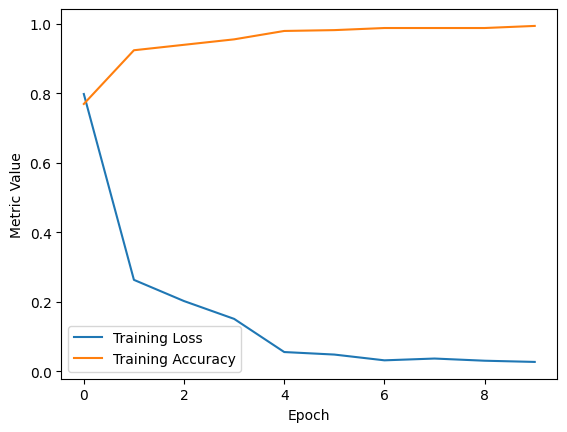

In [7]:


# Assuming you've trained your model using model.fit(...) and stored the result in 'history'


# Plot training history
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
#plt.plot(training_history.history['val_loss'], label='Validation Loss')
#plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

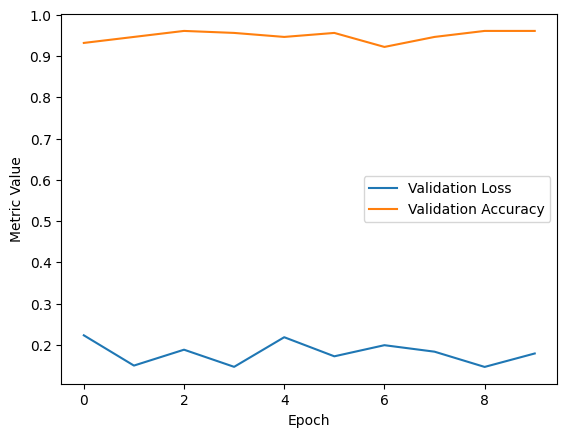

In [8]:
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

In [9]:
tensorboard_callback = TensorBoard(log_dir="logs/train/events.out.tfevents.1701211377.DS-136109.53711.2.v2")


26/26 [==============================] - 40s 1s/step


2023-12-11 22:53:10.391140: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [828]
	 [[{{node Placeholder/_4}}]]
2023-12-11 22:53:10.391298: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [828]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 2s 2s/step
True Label: 1, Predicted Label: 1


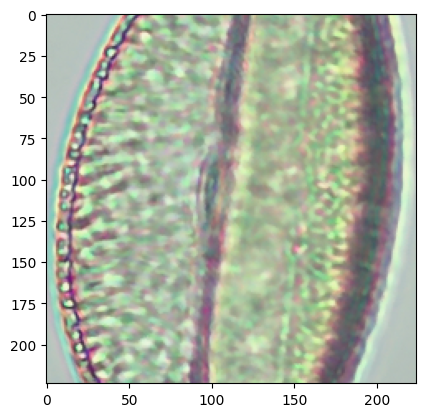

True Label: 4, Predicted Label: 4


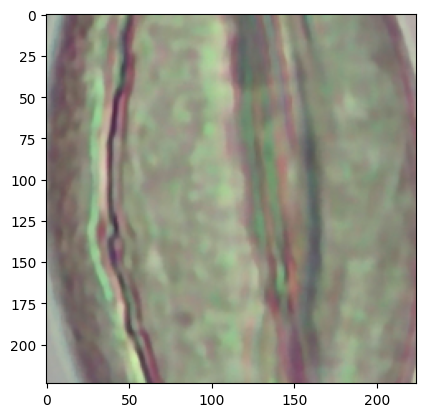

True Label: 3, Predicted Label: 3


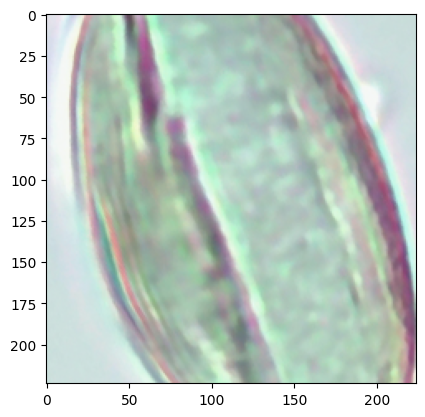

True Label: 0, Predicted Label: 0


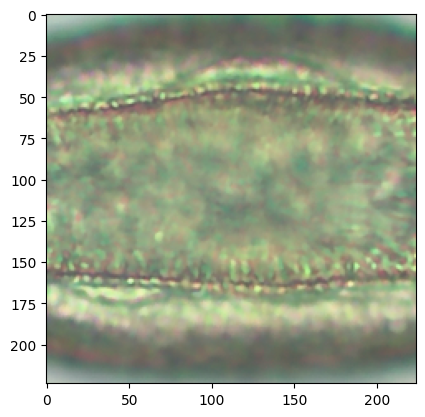

True Label: 2, Predicted Label: 2


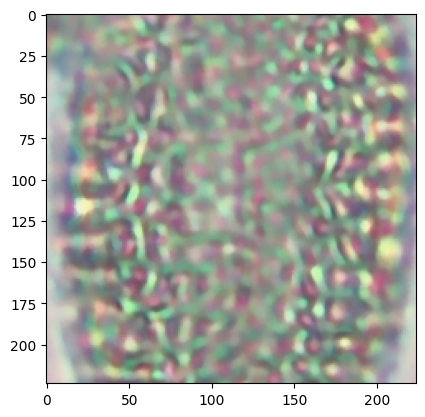

True Label: 0, Predicted Label: 0


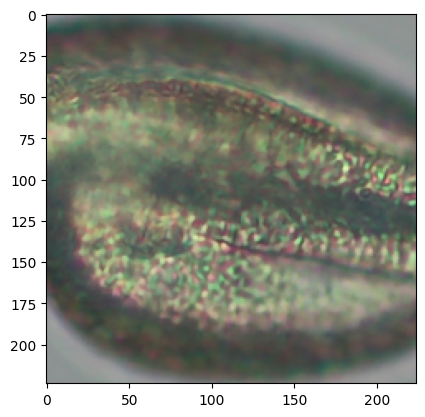

True Label: 0, Predicted Label: 0


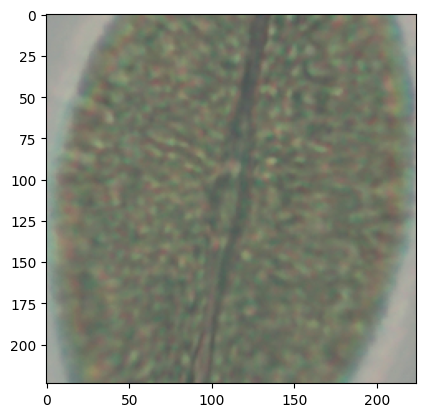

True Label: 0, Predicted Label: 0


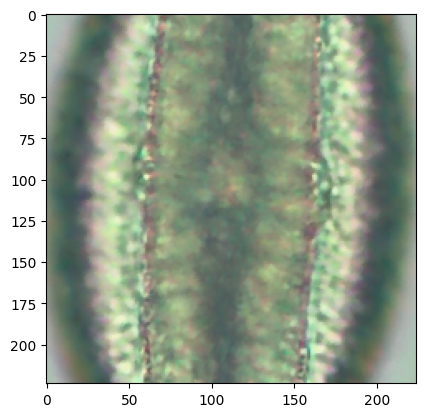

True Label: 3, Predicted Label: 3


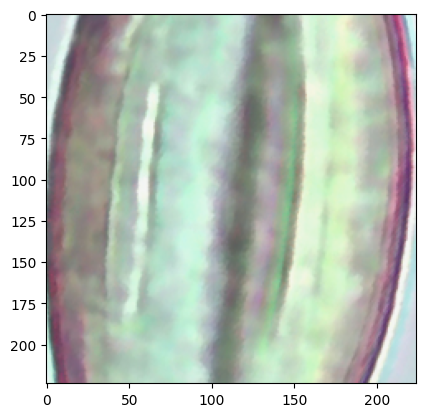

True Label: 4, Predicted Label: 4


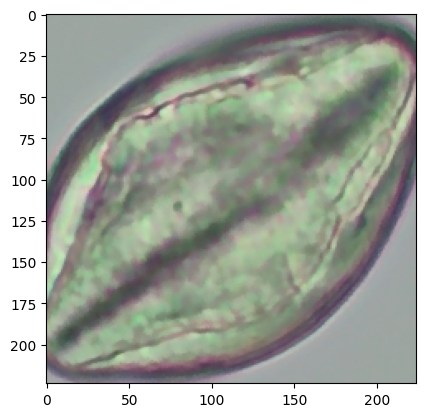

True Label: 0, Predicted Label: 0


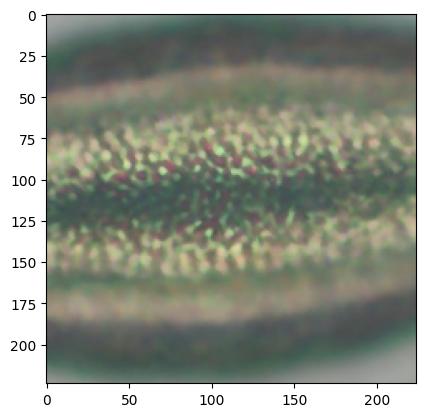

True Label: 3, Predicted Label: 3


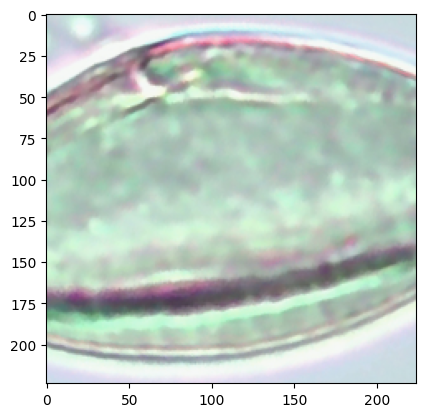

True Label: 0, Predicted Label: 0


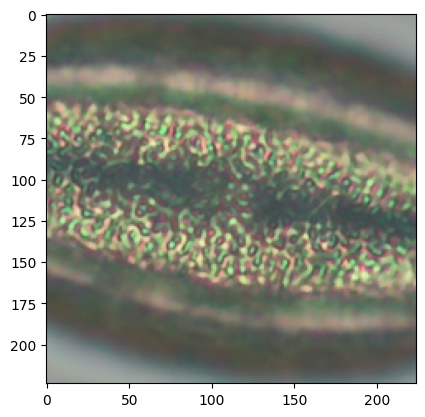

True Label: 2, Predicted Label: 2


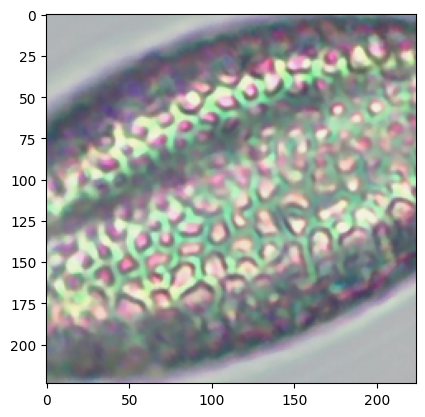

True Label: 2, Predicted Label: 2


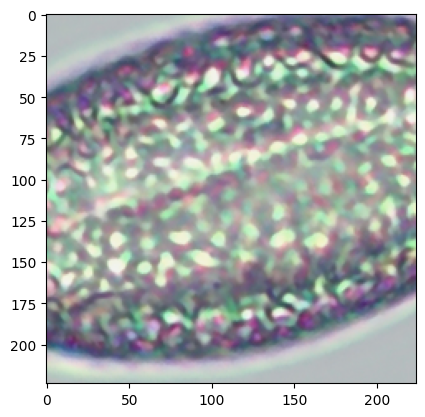

True Label: 3, Predicted Label: 3


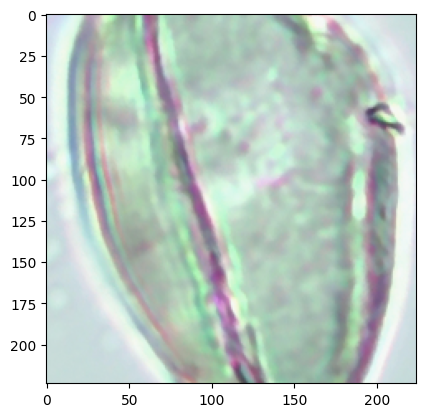

True Label: 3, Predicted Label: 3


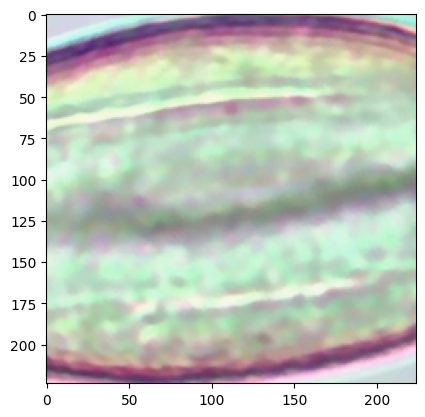

True Label: 2, Predicted Label: 2


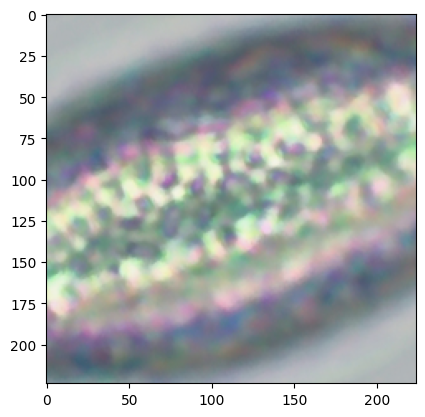

True Label: 2, Predicted Label: 2


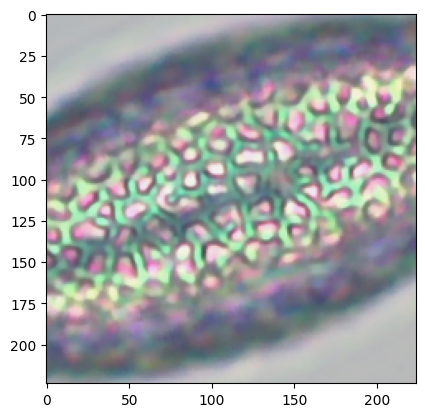

True Label: 3, Predicted Label: 3


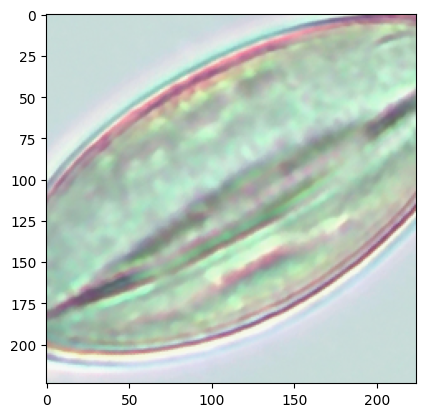

True Label: 2, Predicted Label: 2


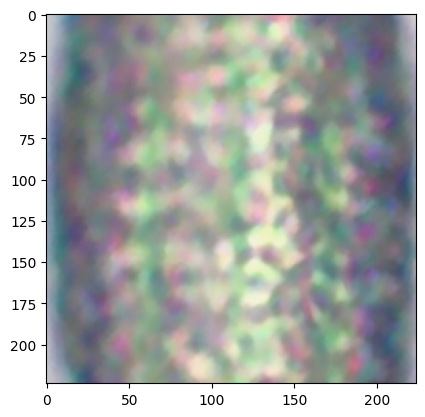

True Label: 2, Predicted Label: 2


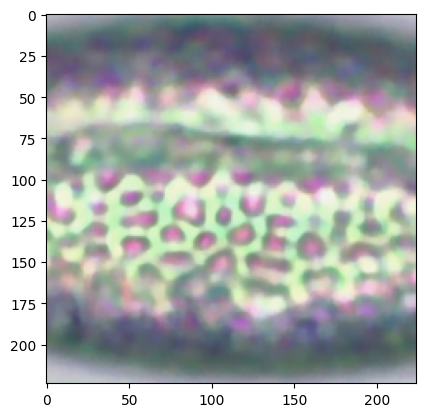

True Label: 1, Predicted Label: 1


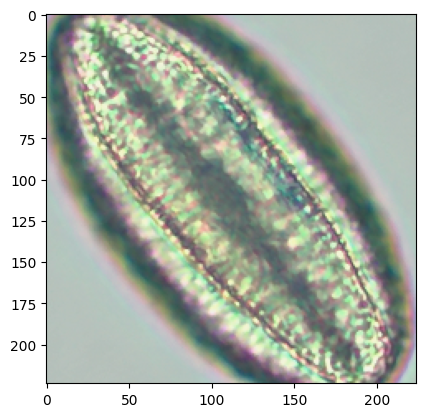

True Label: 4, Predicted Label: 4


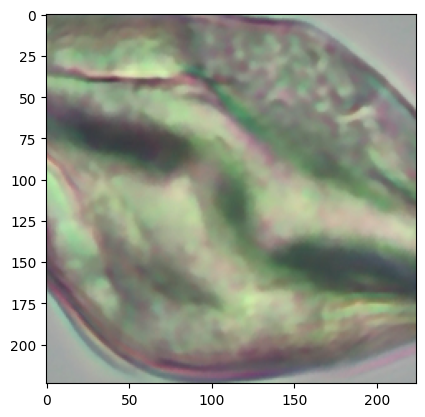

True Label: 0, Predicted Label: 0


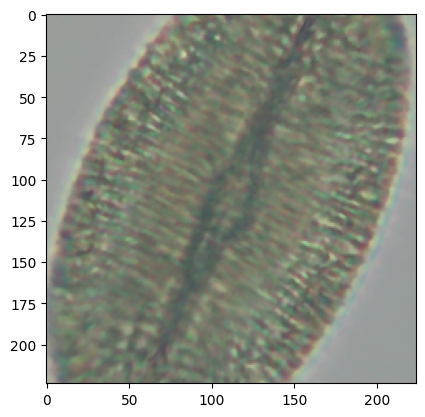

True Label: 3, Predicted Label: 3


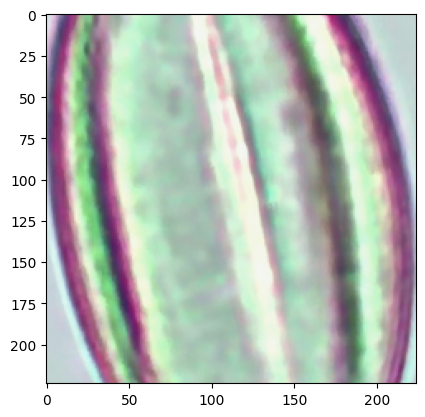

True Label: 3, Predicted Label: 3


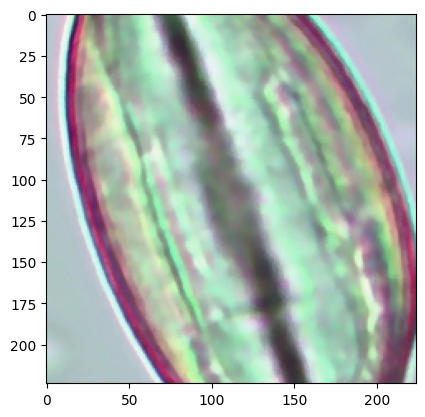

True Label: 4, Predicted Label: 4


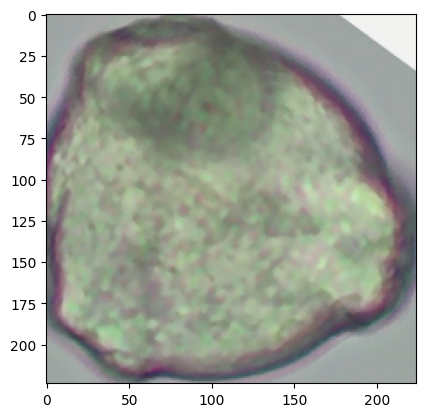

True Label: 0, Predicted Label: 0


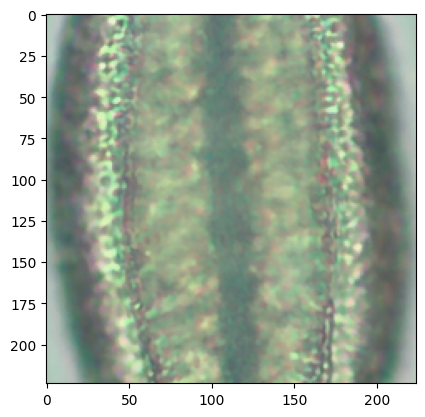

True Label: 2, Predicted Label: 2


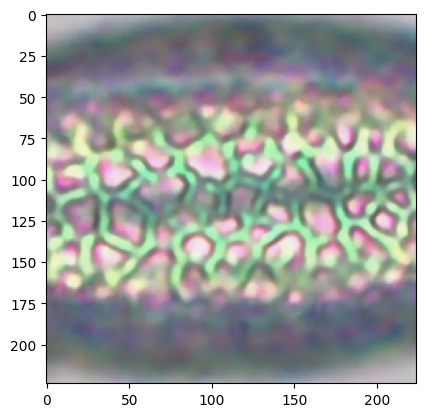

True Label: 0, Predicted Label: 0


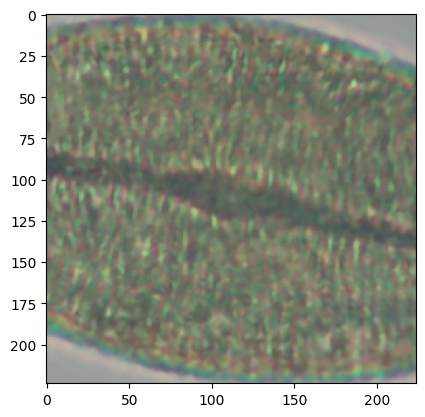

True Label: 3, Predicted Label: 3


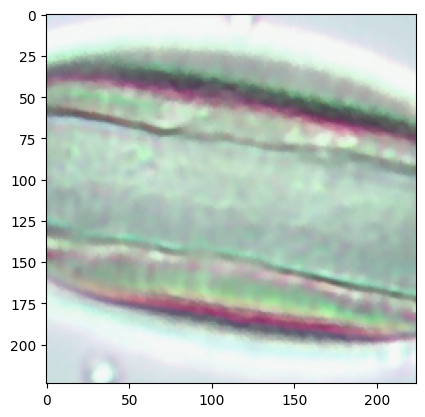

In [14]:

# Assuming you've trained your model and have a trained_model variable
# and test_dataset contains test data
predictions = trained_model.predict(train_dataset)

for images, true_labels in train_dataset.take(1):
    predicted_labels = trained_model.predict(images)

    for i in range(len(images)):
        true_label = np.argmax(true_labels[i])
        predicted_label = np.argmax(predicted_labels[i])

        print(f"True Label: {true_label}, Predicted Label: {predicted_label}")

        # You can display the image using a suitable method, e.g., matplotlib
        plt.imshow(images[i].numpy())
        plt.show()


In [23]:
# Make Predictions
predictions = trained_model.predict(train_dataset)

# Convert Predictions to Class Labels
predicted_labels = np.argmax(predictions, axis=1)

true_label = np.argmax(true_labels)
predicted_label = np.argmax(predicted_labels)
    # Convert Predictions to Class Labels
    # Compute Confusion Matrix
conf_matrix = tf.math.confusion_matrix(true_labels, predicted_labels)


26/26 [==============================] - 41s 2s/step


InvalidArgumentError: {{function_node __wrapped__Pack_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Shapes of all inputs must match: values[0].shape = [32,5] != values[1].shape = [828] [Op:Pack] name: stack